In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'genre-classification-dataset-imdb:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1417162%2F2347441%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T093502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab01a1ede53f175cc9a6c2f7e0a3cc79ad8d695d65e0fab9c3855608c178e6c4b9f7d7b8a8c7ebb3cbec53739814268faa7bdfb38dea190087477947afdfd7ed62301dcc3aa1b5a95136c03ffa1c9911dcaaee4891ff4bf84351a4fb4e601c3d0aaabeaaf0501434503aa18878f8a96503208bb0ff47ad950f7f1bd91f635362f814579f4aa97ccf5d5e8e8392fd12b9e18f7880d3f50a085036b353fce472979ab53129da2d01e89b69bb6636b5955ea12f021300d24d53f3bd17361c0198b71bf7fcecc922db7ce27e75d24015eef7397588b13d4de0b3b547eb97ece7bf26ccd3255c910aecd4b95e93cd49cd5f7da28070dbecf470e44217bb3142655ff8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 43729690 bytes downloaded
Downloaded and uncompressed: genre-classification-dataset-imdb
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
# linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
display(df.head())
print(df.shape)

<ipython-input-5-6f88286cddd4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


(54214, 4)


import re
def clean_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [6]:
df[0:1]

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...


In [7]:
df.drop(columns=['ID','TITLE'],inplace=True)

In [8]:
df.head()

,GENRE,DESCRIPTION
0,drama,Listening in to a conversation between his do...
1,thriller,A brother and sister with a past incestuous r...
2,adult,As the bus empties the students for their fie...
3,drama,To help their unemployed father make ends mee...
4,drama,The film's title refers not only to the un-re...


In [9]:
average_length = df['DESCRIPTION'].str.len().mean()

print(f"The average length of movie descriptions is: {average_length:.2f}")


The average length of movie descriptions is: 600.45


In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
df['DESCRIPTION']=df['DESCRIPTION'].str.lower()

In [12]:
df.head()

,GENRE,DESCRIPTION
0,drama,listening in to a conversation between his do...
1,thriller,a brother and sister with a past incestuous r...
2,adult,as the bus empties the students for their fie...
3,drama,to help their unemployed father make ends mee...
4,drama,the film's title refers not only to the un-re...


In [13]:
import re
def clean_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text
df['DESCRIPTION']=df['DESCRIPTION'].apply(clean_text)
df['DESCRIPTION']

0         listening in to a conversation between his do...
1         a brother and sister with a past incestuous r...
2         as the bus empties the students for their fie...
3         to help their unemployed father make ends mee...
4         the films title refers not only to the unreco...
                               ...                        
54209     this shortlived nbc live sitcom centered on b...
54210     the next generation of exploitation the siste...
54211     ze bestaan echt is a standup comedy about gro...
54212     walter and vivian live in the country and hav...
54213     on labor day weekend 1935 the most intense hu...
Name: DESCRIPTION, Length: 54214, dtype: object

In [14]:
import nltk
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

df['DESCRIPTION'] = df['DESCRIPTION'].apply(stem_text)

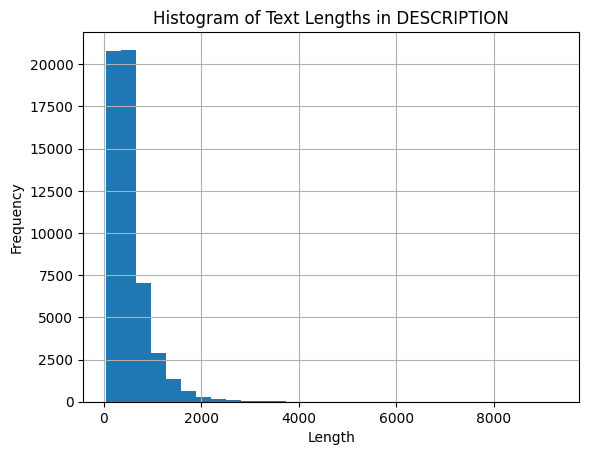

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'DESCRIPTION' is the column with text data
# Calculate the length of each text entry in the 'DESCRIPTION' column
df['length'] = df['DESCRIPTION'].str.len()

# Plot the histogram of the lengths
df['length'].hist(bins=30) # You can adjust the number of bins as needed

# Adding title and labels
plt.title('Histogram of Text Lengths in DESCRIPTION')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


In [15]:
df['DESCRIPTION']

0        listen in to a convers between hi doctor and p...
1        a brother and sister with a past incestu relat...
2        as the bu empti the student for their field tr...
3        to help their unemploy father make end meet ed...
4        the film titl refer not onli to the unrecov bo...
                               ...                        
54209    thi shortliv nbc live sitcom center on bonino ...
54210    the next gener of exploit the sister of kapa b...
54211    ze bestaan echt is a standup comedi about grow...
54212    walter and vivian live in the countri and have...
54213    on labor day weekend 1935 the most intens hurr...
Name: DESCRIPTION, Length: 54214, dtype: object

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'descriptions' is the column name containing the text data
corpus = df['DESCRIPTION']

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the corpus
X = vectorizer.fit_transform(corpus)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, df['GENRE'], test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
# Train a multi-class logistic regression model
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# Make predictions
y_pred = clf.predict(X_test)

In [21]:
y_train_score=clf.predict(X_train)

In [22]:
import numpy as np
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5876602416305451


In [23]:
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Train Accuracy:", accuracy_score(y_train, y_train))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.5876602416305451
Train Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

      action        0.55      0.24      0.33       263
       adult        0.87      0.29      0.44       112
   adventure        0.44      0.14      0.21       139
   animation        0.50      0.04      0.07       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.61      0.56      1443
       crime        0.12      0.01      0.02       107
 documentary        0.66      0.86      0.75      2659
       drama        0.54      0.79      0.65      2697
      family        0.52      0.08      0.14       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.83      0.38      0.52        40
     history        0.00      0.00      0.00        45
      horror        0.66      0.57      0.61       431
       music        0.67      0.42      0.51       144
     musical        0.00      0.00      0.00        50
     mystery        1.00      0.02      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using Deep learning

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, df['GENRE'], test_size=0.2, random_state=42)


In [25]:
from scipy.sparse import coo_matrix
import tensorflow as tf

# Convert Scipy sparse matrix to COO format
coo = coo_matrix(X_train)
coo2 = coo_matrix(X_test)
# Create TensorFlow SparseTensor from COO
tf_idf_matrix_train_tensor = tf.SparseTensor(indices=np.array([coo.row, coo.col]).T, values=coo.data, dense_shape=coo.shape)
tf_idf_matrix_test_tensor = tf.SparseTensor(indices=np.array([coo2.row, coo2.col]).T, values=coo2.data, dense_shape=coo2.shape)

# Reorder the SparseTensor
tf_idf_matrix_train_ordered = tf.sparse.reorder(tf_idf_matrix_train_tensor)
tf_idf_matrix_test_ordered = tf.sparse.reorder(tf_idf_matrix_test_tensor)

In [26]:
tf_idf_matrix_train_ordered

SparseTensor(indices=tf.Tensor(
[[     0   3520]
 [     0   3957]
 [     0   5478]
 ...
 [ 43370 103105]
 [ 43370 111185]
 [ 43370 112481]], shape=(2901161, 2), dtype=int64), values=tf.Tensor([0.13694591 0.0961058  0.04620417 ... 0.06922105 0.08915892 0.12211975], shape=(2901161,), dtype=float64), dense_shape=tf.Tensor([ 43371 115168], shape=(2,), dtype=int64))

In [27]:
# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the target variable to one-hot encoded format
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train_encoded, num_classes=27)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=27)

In [30]:
import gensim
from gensim.models import KeyedVectors
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [40]:
word2vec_model=KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz',binary=True)


In [ ]:
# from keras.preprocessing.sequence import pad_sequences

# padded_train_data = pad_sequences(tf_idf_matrix_train_ordered, maxlen=1000, padding='post', truncating='post', value=0)
# padded_test_data = pad_sequences(tf_idf_matrix_test_ordered, maxlen=1000, padding='post', truncating='post', value=0)


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.initializers import Constant

In [48]:

embedding_matrix = word2vec_model.vectors
vocab_size, embedding_dim = embedding_matrix.shape


In [49]:
input_layer = Input(shape=(1000,))

In [ ]:
embedding_layer = Embedding(vocab_size,
                            100,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)(input_layer)

In [ ]:
# CNN layers
conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=5)(conv2)
flat = Flatten()(pool2)

In [ ]:
# LSTM layer
lstm = LSTM(128)(embedding_layer)

# Concatenate CNN and LSTM outputs
concatenated = tf.keras.layers.concatenate([flat, lstm], axis=-1)

In [ ]:
# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated)
output_layer = Dense(27, activation='softmax')(dense1)  # 27 classes for movie genre classification

In [ ]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

In [35]:
# model = Sequential()

# # CNN Part
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 1))) # Adjust input_shape according to your data
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten()) # Flatten the CNN output to feed it into the LSTM

# # LSTM Part
# model.add(LSTM(128, return_sequences=True)) # Use return_sequences=True if you want to return the full sequence
# model.add(LSTM(128)) # Another LSTM layer

# # Output Layer
# model.add(Dense(1, activation='sigmoid')) # Adjust the number of units and activation function based on your task


ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)

In [ ]:
# # Define the input shape
# input_shape = tf_idf_matrix_train_ordered.shape[1]

# # Define the deep learning model
# model = Sequential()
# model.add(Dense(256, activation='relu', input_shape=(input_shape,)))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(27, activation='softmax'))  # Output layer with 27 units for 27 classes

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(tf_idf_matrix_train_ordered, y_train_one_hot, epochs=10, batch_size=128, validation_data=(tf_idf_matrix_test_ordered, y_test_one_hot))

# # Evaluate the model
# _, accuracy = model.evaluate(tf_idf_matrix_test_ordered, y_test_one_hot)
# print('Test accuracy:', accuracy)